In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#create Spark session
spark = SparkSession.builder.appName('Stackoverflow_Project').getOrCreate()

#change configuration settings on Spark 
conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '5g'), 
                                        ('spark.app.name', 'Spark Updated Conf'), 
                                        ('spark.executor.cores', '4'), 
                                        ('spark.cores.max', '4'), 
                                        ('spark.driver.memory','8g')])

In [3]:
#if you have limited memory - ignore this second dataset
df = spark.read \
    .option("quote", "\"")  \
    .option("escape", "\"") \
    .option("ignoreLeadingWhiteSpace",True) \
    .parquet("gs://msca-bdp-student-gcs/Group6/extracted_StackOverflow.parquet",inferSchema=True, header=True )

In [4]:
df.count()

2605413

In [5]:
df.show(5)

24/12/02 05:37:26 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------+--------------------+--------------------+-----------------------+-----------------+------------------+------------------+-------------------+-----------------------+-------------------+------------------------+------------------+-----------------+----------+--------------------+---------------+---------+--------------------+--------------------+--------------------+-------------------------+---------------------+--------------------------+--------------------+----------------+-------------------+------------+--------------------+--------------------+
| post_id|          post_title|           post_body|post_accepted_answer_id|post_answer_count|post_comment_count|post_creation_date|post_favorite_count|post_last_activity_date|post_last_edit_date|post_last_editor_user_id|post_owner_user_id|post_post_type_id|post_score|           post_tags|post_view_count|answer_id|         answer_body|answer_comment_count|answer_creation_date|answer_last_activity_date|answer_last_edit_date|answe

In [6]:
df.printSchema()

root
 |-- post_id: long (nullable = true)
 |-- post_title: string (nullable = true)
 |-- post_body: string (nullable = true)
 |-- post_accepted_answer_id: long (nullable = true)
 |-- post_answer_count: long (nullable = true)
 |-- post_comment_count: long (nullable = true)
 |-- post_creation_date: date (nullable = true)
 |-- post_favorite_count: long (nullable = true)
 |-- post_last_activity_date: date (nullable = true)
 |-- post_last_edit_date: date (nullable = true)
 |-- post_last_editor_user_id: long (nullable = true)
 |-- post_owner_user_id: long (nullable = true)
 |-- post_post_type_id: long (nullable = true)
 |-- post_score: long (nullable = true)
 |-- post_tags: string (nullable = true)
 |-- post_view_count: long (nullable = true)
 |-- answer_id: long (nullable = true)
 |-- answer_body: string (nullable = true)
 |-- answer_comment_count: long (nullable = true)
 |-- answer_creation_date: long (nullable = true)
 |-- answer_last_activity_date: date (nullable = true)
 |-- answer_last

In [7]:
#Count rows with missing values
df.dropna().count() #no duplicates

369090

In [8]:
df.select('post_body','post_body_text','post_body_code').show(10)

+--------------------+--------------------+--------------------+
|           post_body|      post_body_text|      post_body_code|
+--------------------+--------------------+--------------------+
|<p>I follow the s...| i follow the ste...|                    |
|<p>Is <code>sizeo...| is the equivalen...|sizeof(size_t)==8...|
|<p>I'm a newbie a...| i m a newbie and...|$ pip install pyS...|
|<p>I have a situa...| i have a situati...|Student Names Add...|
|<p>After catching...| after catching a...| do{ //Begin of l...|
|<p>I currently ha...| i currently have...|                    |
|<p>I want to vali...| i want to valida...|formvalidate({ ru...|
|<p>This is an exa...| this is an examp...|function func1() ...|
|<p>i want to atta...| i want to attach...|package comzlaand...|
|<p>I read the doc...| i read the docum...|                    |
+--------------------+--------------------+--------------------+
only showing top 10 rows



In [9]:
posts_df = df.select('post_body_text','post_creation_date').groupBy('post_body_text','post_creation_date').count()
posts_df = posts_df.withColumnRenamed('count', 'Count of Answers')

In [10]:
posts_df.show(5)

+--------------------+------------------+----------------+
|      post_body_text|post_creation_date|Count of Answers|
+--------------------+------------------+----------------+
| as the title sta...|        2010-06-03|               6|
| i am adding a pa...|        2011-11-29|              10|
| need some help i...|        2010-09-14|               8|
| i need to traver...|        2011-09-28|               6|
| i am trying to f...|        2011-02-06|               7|
+--------------------+------------------+----------------+
only showing top 5 rows



In [11]:
from sparknlp.base import DocumentAssembler
from sparknlp.annotator import UniversalSentenceEncoder, SentimentDLModel
from pyspark.ml import Pipeline

# Step 1: DocumentAssembler
document_assembler = DocumentAssembler() \
    .setInputCol("post_body_text") \
    .setOutputCol("document")

# Step 2: Universal Sentence Encoder (optional for embeddings)
use_embeddings = UniversalSentenceEncoder.pretrained("tfhub_use", "en") \
    .setInputCols(["document"]) \
    .setOutputCol("sentence_embeddings")

# Step 3: SentimentDLModel
sentiment_dl = SentimentDLModel.pretrained("sentimentdl_use_twitter","en") \
    .setInputCols(["sentence_embeddings"]) \
    .setOutputCol("sentiment")

#sentimentdl_use_imdb - other pre-trained model that we can use, however it is trained on reviews
#whereas tweets are more generic and hence we can use it for our data.

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[ / ]tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[ \ ]Download done! Loading the resource.
[ | ]

[ / ]

[ | ]

2024-12-02 05:38:49.848331: I external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[OK!]
sentimentdl_use_twitter download started this may take some time.
Approximate size to download 11.4 MB
[ / ]sentimentdl_use_twitter download started this may take some time.
Approximate size to download 11.4 MB
Download done! Loading the resource.
[ — ]

24/12/02 05:39:12 WARN org.apache.hadoop.util.concurrent.ExecutorHelper: Thread (Thread[GetFileInfo #1,5,main]) interrupted: 
java.lang.InterruptedException
	at com.google.common.util.concurrent.AbstractFuture.get(AbstractFuture.java:510)
	at com.google.common.util.concurrent.FluentFuture$TrustedFuture.get(FluentFuture.java:88)
	at org.apache.hadoop.util.concurrent.ExecutorHelper.logThrowableFromAfterExecute(ExecutorHelper.java:48)
	at org.apache.hadoop.util.concurrent.HadoopThreadPoolExecutor.afterExecute(HadoopThreadPoolExecutor.java:90)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1157)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:750)


[OK!]


In [12]:
# Update the pipeline
nlp_pipeline = Pipeline(stages=[
    document_assembler,  # Generates the 'document' column
    use_embeddings,      # Creates sentence embeddings from documents
    sentiment_dl         # Performs sentiment analysis
])

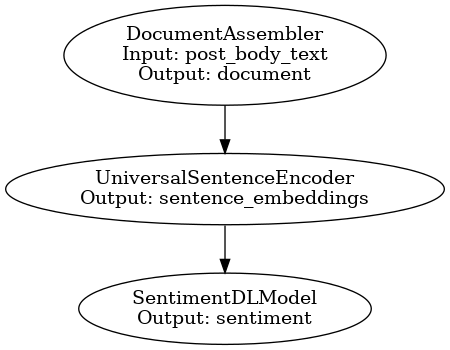

In [66]:
from graphviz import Digraph

# Create a directed graph
dot = Digraph(comment='NLP Pipeline')

# Add nodes for each stage
dot.node('A', 'DocumentAssembler\nInput: post_body_text\nOutput: document')
dot.node('B', 'UniversalSentenceEncoder\nOutput: sentence_embeddings')
dot.node('C', 'SentimentDLModel\nOutput: sentiment')

# Add edges to represent the flow
dot.edges(['AB', 'BC'])

# Save and render the graph
dot.render('nlp_pipeline', format='png', cleanup=True)

# Show the generated visualization (if running locally)
from IPython.display import Image
Image('nlp_pipeline.png')

In [16]:
# Fit and transform the data
nlp_model = nlp_pipeline.fit(posts_df)
nlp_model

PipelineModel_b052d9f8e99f

In [17]:
sentiment_df = nlp_model.transform(posts_df)

In [18]:
# Select relevant columns
sentiment_df_2 = sentiment_df.select("post_body_text","post_creation_date",
                                     "Count of Answers", "sentiment.result")
sentiment_df_2.show(5,truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------+----------------+----------+
|post_body_text                                                                                                                                                                                         

In [19]:
sentiment_df_2 = sentiment_df_2.withColumn(
    "sentiment_score",
    F.when(F.expr("result[0] == 'positive'"), 1.0)
    .when(F.expr("result[0] == 'negative'"), 0.0)
    .otherwise(0.5) #neutral
)

In [20]:
sentiment_df_2.printSchema()

root
 |-- post_body_text: string (nullable = true)
 |-- post_creation_date: date (nullable = true)
 |-- Count of Answers: long (nullable = false)
 |-- result: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- sentiment_score: double (nullable = false)



In [23]:
from pyspark.sql.functions import col, year, month, count, explode

# Extract month/year from the post_creation_date
sentiment_df_aggregated = sentiment_df_2.withColumn("year", year("post_creation_date")) \
                                        .withColumn("month", month("post_creation_date")) \
                                        .groupBy("year", "month", "sentiment_score") \
                                        .agg(count("*").alias("post_count")).orderBy("year", "month", "sentiment_score")

In [24]:
sentiment_df_aggregated.show(3)

+----+-----+---------------+----------+
|year|month|sentiment_score|post_count|
+----+-----+---------------+----------+
|2008|    7|            0.0|         4|
|2008|    8|            0.0|      1265|
|2008|    8|            0.5|        52|
+----+-----+---------------+----------+
only showing top 3 rows



In [26]:
sentiment_df_aggregated = sentiment_df_aggregated.withColumn(
    "sentiment",
    F.when(F.expr("sentiment_score == 1.0"), "positive")
    .when(F.expr("sentiment_score == 0.0"), "negative")
    .otherwise("neutral") 
)

sentiment_df_aggregated.show()

+----+-----+---------------+----------+---------+
|year|month|sentiment_score|post_count|sentiment|
+----+-----+---------------+----------+---------+
|2008|    7|            0.0|         4| negative|
|2008|    8|            0.0|      1265| negative|
|2008|    8|            0.5|        52|  neutral|
|2008|    8|            1.0|       998| positive|
|2008|    9|            0.0|      4481| negative|
|2008|    9|            0.5|       158|  neutral|
|2008|    9|            1.0|      2903| positive|
|2008|   10|            0.0|      3765| negative|
|2008|   10|            0.5|       130|  neutral|
|2008|   10|            1.0|      2270| positive|
|2008|   11|            0.0|      2811| negative|
|2008|   11|            0.5|        92|  neutral|
|2008|   11|            1.0|      1469| positive|
|2008|   12|            0.0|      2583| negative|
|2008|   12|            0.5|        80|  neutral|
|2008|   12|            1.0|      1420| positive|
|2009|    1|            0.0|      3242| negative|


In [27]:
# Convert PySpark DataFrame to Pandas for easier plotting
sentiment_pd = sentiment_df_aggregated.toPandas()

# Create a new column for Month/Year representation
sentiment_pd['month_year'] = sentiment_pd['year'].astype(str) + '-' + sentiment_pd['month'].astype(str).str.zfill(2)

# Pivot data to get separate columns for each sentiment
sentiment_pivot = sentiment_pd.pivot(index='month_year', columns='sentiment', values='post_count').fillna(0)
sentiment_pivot.reset_index(inplace=True)
sentiment_pivot.head()

sentiment,month_year,negative,neutral,positive
0,2008-07,4.0,0.0,0.0
1,2008-08,1265.0,52.0,998.0
2,2008-09,4481.0,158.0,2903.0
3,2008-10,3765.0,130.0,2270.0
4,2008-11,2811.0,92.0,1469.0


In [33]:
sentiment_pivot = sentiment_pivot.iloc[1:,:]

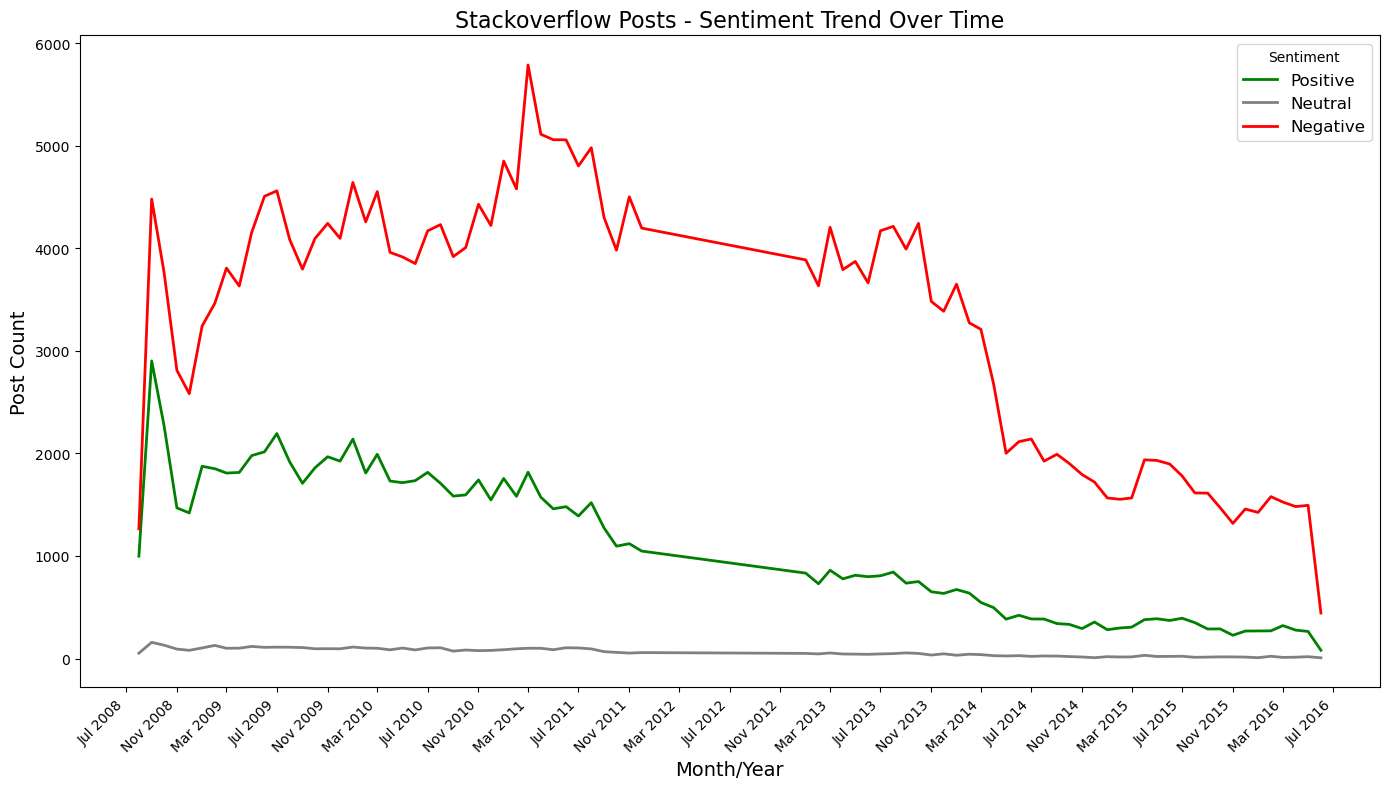

In [65]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import pandas as pd

# Ensure the month_year column is a datetime type for better axis formatting
sentiment_pivot['month_year'] = pd.to_datetime(sentiment_pivot['month_year'], format='%Y-%m')

# Plot the sentiment trends over time
plt.figure(figsize=(14, 8))
plt.plot(
    sentiment_pivot['month_year'], sentiment_pivot.get('positive', 0), 
    label='Positive', color='green', linewidth=2
)
plt.plot(
    sentiment_pivot['month_year'], sentiment_pivot.get('neutral', 0), 
    label='Neutral', color='grey', linewidth=2
)
plt.plot(
    sentiment_pivot['month_year'], sentiment_pivot.get('negative', 0), 
    label='Negative', color='red', linewidth=2
)

# Formatting the x-axis to prevent overlap
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4))  # Show every 4th month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format as "Month Year"
plt.gcf().autofmt_xdate()  # Auto-rotate dates for better readability

# Add labels, title, and legend
plt.title('Stackoverflow Posts - Sentiment Trend Over Time', fontsize=16)
plt.xlabel('Month/Year', fontsize=14)
plt.ylabel('Post Count', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title="Sentiment", fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()

### Correlation b/w sentiment and count of answers

In [43]:
sentiment_df_2.groupBy(["result", "sentiment_score"]).count().show()

+----------+---------------+------+
|    result|sentiment_score| count|
+----------+---------------+------+
|[negative]|            0.0|272611|
|[positive]|            1.0| 90015|
| [neutral]|            0.5|  5050|
+----------+---------------+------+



In [46]:
#Top posts by view counts have positive sentiment
sentiment_df_2.orderBy("Count of Answers",ascending=False).show(5)

+--------------------+------------------+----------------+----------+---------------+
|      post_body_text|post_creation_date|Count of Answers|    result|sentiment_score|
+--------------------+------------------+----------------+----------+---------------+
| what is the best...|        2008-10-08|             518|[positive]|            1.0|
| this is definite...|        2009-01-02|             407|[positive]|            1.0|
| what is in your ...|        2010-01-03|             320|[positive]|            1.0|
| this came to my ...|        2008-08-12|             296|[positive]|            1.0|
| if you could go ...|        2008-08-04|             214|[positive]|            1.0|
+--------------------+------------------+----------------+----------+---------------+
only showing top 5 rows



In [47]:
#Bottom posts by view counts don't necessarily have a negative sentiment
sentiment_df_2.orderBy("Count of Answers").show(5)

+--------------------+------------------+----------------+----------+---------------+
|      post_body_text|post_creation_date|Count of Answers|    result|sentiment_score|
+--------------------+------------------+----------------+----------+---------------+
| how to check whe...|        2013-12-18|               1|[negative]|            0.0|
| does anyone know...|        2010-03-24|               1|[positive]|            1.0|
| i have an applic...|        2010-03-18|               1|[negative]|            0.0|
| howto list all d...|        2011-01-07|               1|[positive]|            1.0|
| so my css looks ...|        2016-03-23|               1|[negative]|            0.0|
+--------------------+------------------+----------------+----------+---------------+
only showing top 5 rows



In [44]:
# Compute correlation between sentiment_score and number_of_answers
correlation = sentiment_df_2.stat.corr("sentiment_score", "Count of Answers")

In [45]:
#Indicates no correlation b/w sentiment and count of answers
print(f"Correlation between sentiment and number of answers: {correlation}")

Correlation between sentiment and number of answers: 0.01893180882700611


In [48]:
# Prepare the data
scatter_data = sentiment_df_2.toPandas()  # Convert to pandas for easier plotting

In [51]:
scatter_data.head()

,post_body_text,post_creation_date,Count of Answers,result,sentiment_score
0,i have a query that looks something like this...,2013-01-30,5,[negative],0.0
1,let s say i have a data like this kendo grid ...,2014-01-02,6,[negative],0.0
2,i have an array that looks like this i want t...,2013-07-29,7,[negative],0.0
3,i want to have three check boxes and their la...,2014-03-21,6,[negative],0.0
4,there s this extra space below the buttons an...,2013-05-27,5,[negative],0.0


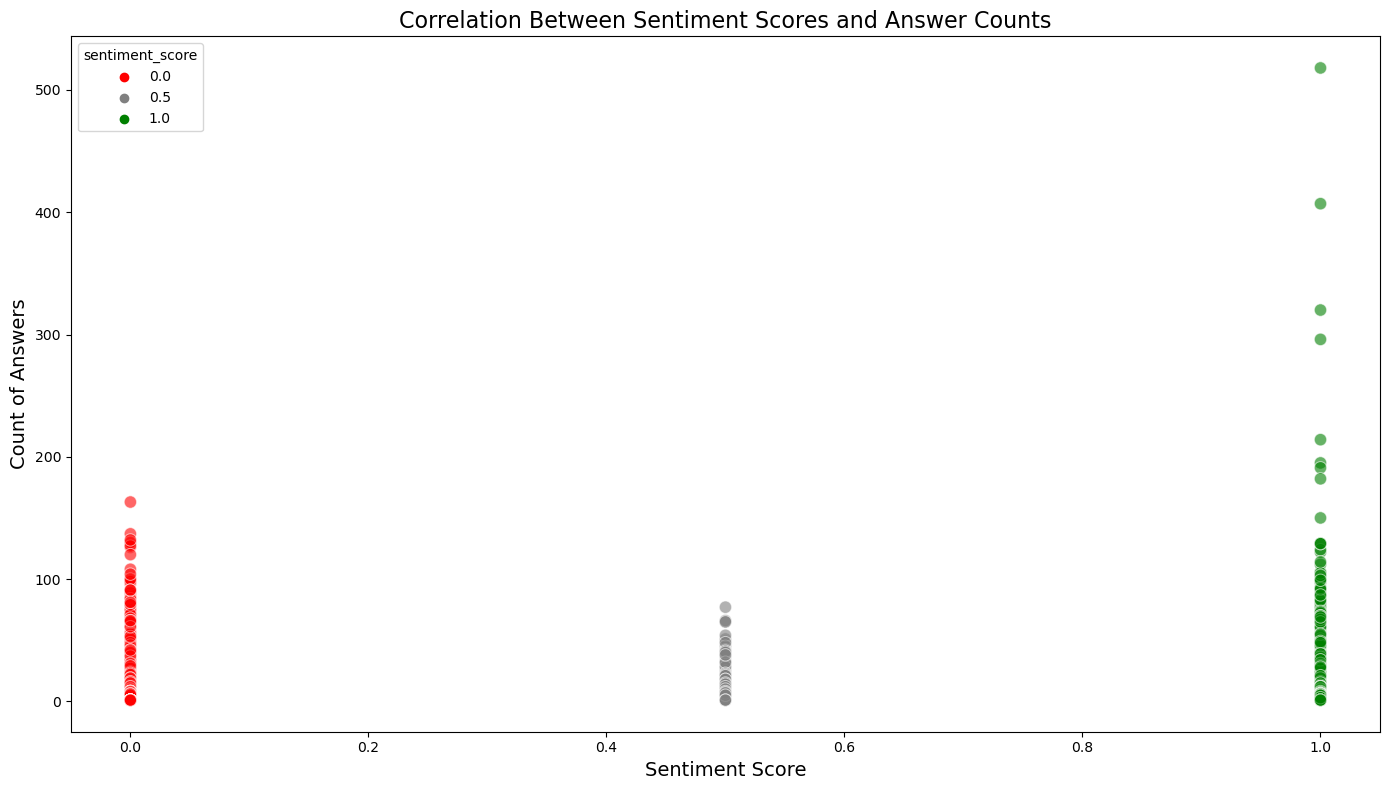

In [54]:
import seaborn as sns

# Plot scatter plot
plt.figure(figsize=(14, 8))
sns.scatterplot(
    data=scatter_data, 
    x='sentiment_score', 
    y='Count of Answers', 
    hue='sentiment_score',  # Color by sentiment
    palette={1.0: 'green', 0.5: 'grey', 0.0: 'red'},
    alpha=0.6,
    s=80
)

# Add trend lines (regression lines)
sns.regplot(
    data=scatter_data[scatter_data['sentiment_score'] == 1.0], 
    x='sentiment_score', 
    y='Count of Answers', 
    scatter=False, color='green', label='Positive Trend'
)
sns.regplot(
    data=scatter_data[scatter_data['sentiment_score'] == 0.5], 
    x='sentiment_score', 
    y='Count of Answers', 
    scatter=False, color='grey', label='Neutral Trend'
)
sns.regplot(
    data=scatter_data[scatter_data['sentiment_score'] == 0.0], 
    x='sentiment_score', 
    y='Count of Answers', 
    scatter=False, color='red', label='Negative Trend'
)

# Add labels, title, and legend
plt.title('Correlation Between Sentiment Scores and Answer Counts', fontsize=16)
plt.xlabel('Sentiment Score', fontsize=14)
plt.ylabel('Count of Answers', fontsize=14)
#plt.legend(title="Sentiment Type", fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()

## Also trying with post favorite counts

In [55]:
posts_df_2 = df.groupBy('post_body_text') \
    .agg(
        F.count('*').alias('Count of Answers'),
        F.avg('post_favorite_count').alias('Post Favorite Count')
    )

posts_df_2.show()

+--------------------+----------------+-------------------+
|      post_body_text|Count of Answers|Post Favorite Count|
+--------------------+----------------+-------------------+
| how do i return ...|               5|                0.0|
| i m just doing s...|               5|               null|
| i tried to make ...|               4|                1.0|
| i m trying to un...|               5|               null|
| i got a problem ...|               5|               null|
| i want to know h...|               6|                1.0|
| i am trying to l...|               5|               null|
| i have create my...|               5|                0.0|
| i have searched ...|               5|               null|
| given number of ...|               5|               null|
| i am looking for...|               5|               null|
| postgresql just ...|               9|               37.0|
| i am using vs201...|               8|                2.0|
| main cassroll pr...|               6| 

In [56]:
nlp_model_2 = nlp_pipeline.fit(posts_df_2)
nlp_model_2

PipelineModel_4e410a45cb9d

In [57]:
sentiment_df_v2 = nlp_model_2.transform(posts_df_2)

In [58]:
# Select relevant columns
sentiment_df_v2 = sentiment_df_v2.select("post_body_text", "Count of Answers",
                                         "Post Favorite Count","sentiment.result")

In [59]:
sentiment_df_v2 = sentiment_df_v2.withColumn(
    "Sentiment Score",
    F.when(F.expr("result[0] == 'positive'"), 1.0)
    .when(F.expr("result[0] == 'negative'"), 0.0)
    .otherwise(0.5) #neutral
)

sentiment_df_v2.printSchema()

root
 |-- post_body_text: string (nullable = true)
 |-- Count of Answers: long (nullable = false)
 |-- Post Favorite Count: double (nullable = true)
 |-- result: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- Sentiment Score: double (nullable = false)



In [60]:
# Compute correlation between sentiment_score and number_of_answers
correlation_2 = sentiment_df_v2.stat.corr("Sentiment Score", "Post Favorite Count")

In [61]:
print(f"Correlation between sentiment and post favorite count: {correlation_2}")

Correlation between sentiment and post favorite count: 0.03869474162682189


In [62]:
#This is also low.

In [64]:
sentiment_df_v2.groupBy(["result", "Sentiment Score"]).count().show()

+----------+---------------+------+
|    result|Sentiment Score| count|
+----------+---------------+------+
|[negative]|            0.0|272597|
|[positive]|            1.0| 89689|
| [neutral]|            0.5|  5050|
+----------+---------------+------+

